## 텍스트 생성 - 한글->영어 기계 번역

In [2]:
# 사용 모듈 import
import os
import pandas as pd
import numpy as np
from pprint import pprint

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, SimpleRNN, Input
from tensorflow.keras.utils import to_categorical

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

In [4]:
# 데이터가 있는 폴더 위치 설정 
d_path = '../data/KEnglish_Text_Corpus_sample/'

# 내부 파일 확인하기
files = os.listdir(d_path)
print(files)

['1_구어체_190920.xlsx', '2_대화체_190920.xlsx', '3_문어체_뉴스_190920.xlsx', '4_문어체_한국문화_190920.xlsx', '5_문어체_조례_190920.xlsx', '6_문어체_지자체웹사이트_190920.xlsx']


In [6]:
# 1_구어체_190920.xlsx 데이터 
# pandas로 읽어서 DataFrame 생성하기
# 및 확인하기
xlsx = pd.read_excel(d_path+files[0])
print(xlsx)

       Temp                               한국어  \
0     15005  나는 네가 한국 언어를 배워서 한국어로 대화했으면 좋겠어.   
1     15006  나는 대략 한 시간 정도 이 창고를 돌아 보기를 원합니다.   
2     15007   때를 미는 한국의 목욕법을 체험해보고 싶은데 가능할까요?   
3     15008    우리들 또한 당신들과 함께 한다면 큰 영광일 것입니다.   
4     15016      나는 네가 한국의 감탄사를 사용한다는 말에 놀랐다.   
...     ...                               ...   
9994   2229           아침에 물 흐르는 좋은 소리를 들었습니다.   
9995   2240         Anne은 여름 휴가를 어떻게 보낼 것인가요?   
9996   2242            이번 여름 휴가는 일본에 가려고 했어요.   
9997   2243              설 연휴 휴무 일정이 어떻게 되나요?   
9998   2251           나는 올해 휴가 때 사이판을 다녀왔습니다.   

                                                     영어  \
0     I want you to learn Korean and talk with me in...   
1     I want to look around this warehouse for about...   
2     I want to experience Korean skin peeling, but ...   
3     It will be truly honored for us to work with you.   
4     I was surprised that you used Korea's exclamat...   
...                                                 ...  

In [7]:
# DataFrame에서 한국어만 확인하기
print(xlsx['한국어'])

0       나는 네가 한국 언어를 배워서 한국어로 대화했으면 좋겠어.
1       나는 대략 한 시간 정도 이 창고를 돌아 보기를 원합니다.
2        때를 미는 한국의 목욕법을 체험해보고 싶은데 가능할까요?
3         우리들 또한 당신들과 함께 한다면 큰 영광일 것입니다.
4           나는 네가 한국의 감탄사를 사용한다는 말에 놀랐다.
                      ...               
9994             아침에 물 흐르는 좋은 소리를 들었습니다.
9995           Anne은 여름 휴가를 어떻게 보낼 것인가요?
9996              이번 여름 휴가는 일본에 가려고 했어요.
9997                설 연휴 휴무 일정이 어떻게 되나요?
9998             나는 올해 휴가 때 사이판을 다녀왔습니다.
Name: 한국어, Length: 9999, dtype: object


In [8]:
# DataFrame에서 영어만 확인하기
print(xlsx['영어'])

0       I want you to learn Korean and talk with me in...
1       I want to look around this warehouse for about...
2       I want to experience Korean skin peeling, but ...
3       It will be truly honored for us to work with you.
4       I was surprised that you used Korea's exclamat...
                              ...                        
9994         I heard the water is running in the morning.
9995             How will Anne spend the summer vacation?
9996     I have planned to go Japan this summer vacation.
9997           What are the New Year’s holiday schedules?
9998      I went to Saipan during the vacation this year.
Name: 영어, Length: 9999, dtype: object


In [9]:
# DataFrame에서 한국어의 values만 추출하기(문장만 추출)
kor_sentences = xlsx['한국어'].values

# 한국어 문장의 개수 확인하기
print(len(kor_sentences))

# 한국어 문장 앞에서 5개 확인하기
pprint(kor_sentences[:5])

# 사용할 한국어 문장 개수를 100개로 줄이기
kor_sentences = kor_sentences[:100]

9999
array(['나는 네가 한국 언어를 배워서 한국어로 대화했으면 좋겠어.',
       '나는 대략 한 시간 정도 이 창고를 돌아 보기를 원합니다.',
       '때를 미는 한국의 목욕법을 체험해보고 싶은데 가능할까요?',
       '우리들 또한 당신들과 함께 한다면 큰 영광일 것입니다.', '나는 네가 한국의 감탄사를 사용한다는 말에 놀랐다.'],
      dtype=object)


In [10]:
# DataFrame에서 영어의 values만 추출하기(문장만 추출)
eng_sentences = xlsx['영어'].values

# 영어 문장의 개수 확인하기
print(len(eng_sentences))

# 영어 문장 앞에서 5개 확인하기
pprint(eng_sentences[:5])

# 사용할 영어 문장 개수 100개로 줄이기
eng_sentences = eng_sentences[:100]

9999
array(['I want you to learn Korean and talk with me in Korean.',
       'I want to look around this warehouse for about an hour.',
       'I want to experience Korean skin peeling, but would it be possible?',
       'It will be truly honored for us to work with you.',
       "I was surprised that you used Korea's exclamation."], dtype=object)


In [14]:
# 한글 words_set(단어의 집합) 생성
# 및 한글 문장의 최대길이 확인하기

# set 변수 생성
kor_words_set = set()

# 문장 최대길이 변수 생성
kor_max_len = 0

# enemerate(kor_sentences)로 한국어 문장과 문장의 위치를 함깨 받기
for ix, sentence in enumerate(kor_sentences):
    
    # 문장의 죄우 공백 및 줄바꿈 문자를 제거하고 띄워쓰기로 단어를 나눠서 
    # 각 단어에 다시 공백을 제거해 준 뒤 words에 저장
    words = [word.strip() for word in sentence.strip().split(' ')]
    
    # 한글 문장의 최대길이 업데이트
    if len(words) > kor_max_len:
        kor_max_len = len(words)
    
    # words에 빈 데이터가 들어있으면 제거
    while '' in words:
        words.remove('')
        
    # 한글 단어 집합에 현재 단어들 추가
    kor_words_set.update(words)

In [15]:
# 한글 words_set 확인

# 단어 집합을 정렬한 뒤 타입을 리스트로 변경
kor_words_set = list(sorted(kor_words_set))

# zero-padding을 위해서 한글 단어 집합의 0번째에 공백 추가
kor_words_set.insert(0, '')

# 한글 단어 개수 확인
print('#kor words: ', len(kor_words_set))

# 한글 문장의 최대길이 확인
print('max seq length: ', kor_max_len)

#kor words:  584
max seq length:  12


In [17]:
# 영어 words_set(단어 집합) 생성
# 및 영어 최대 길이 문장 설정

# 영어 단어 집합 변수 생성
eng_words_set = set()

# 영어 최대 길이 변수 생성
eng_max_len = 0

# 영어 문장과 해당 문장이 몇 번째 문장인지 함께 받기
for ix, sentence in enumerate(eng_sentences):
    
    # 문장의 죄우 공백 및 줄바꿈 문자를 제거하고 띄워쓰기로 단어를 나눠서 
    # 각 단어에 다시 공백을 제거해 준 뒤 words에 저장
    words = [word.strip() for word in sentence.strip().split(' ')]
    
    # 영어 문장 최대길이 업데이트
    if len(words) > eng_max_len:
        eng_max_len = len(words)
        
    # words에 빈 데이터가 있으면 제거 
    while '' in words:
        words.remove('')
    
    # 영어 단어 집합에 현재 단어들 추가
    eng_words_set.update(words)
    
# 영어 문장의 시작을 알릴 Special Symbol인 '<start>'와
# 끝을 알릴 pecial Symbol '<eod>'를 영어 단어 집합에 추가
eng_words_set.update(['<start>', '<eos>'])

In [18]:
# 영어 words_set 확인

# 영어 단어 집합을 정렬하고, 리스트로 타입 변경
eng_words_set = list(sorted(eng_words_set))

# zero-padding을 위해서, 영어 단어 집합의 0번째에
# 빈 데이터 추가
eng_words_set.insert(0, '')

# 영어 집합에 있는 단어의 개수 확인
print('#end words', len(eng_words_set))

# 영어 문장의 최대 길이 확인
print('max seq length: ', eng_max_len)

#end words 505
max seq length:  18


In [20]:
# 한국어 문장 정수 인코딩 및 패딩 함수 작성

# 하나의 문장이 입력되면,
# 인코딩 및 패딩을 진행한 데이터로 변경 후 반환
def kor_encoding(sentence):
    
    # 문장에서 공백 및 줄바꿈 문자를 제거하고
    # ' '(띄어쓰기)로 문장을 잘라 단어로 만든다음
    # 단어에서 다시 공백 및 줄바꿈 문자를 제거하고
    # words에 저장
    words = [word.strip() for word in sentence.strip().split(' ')]
    
    # words에서 빈 데이터 제거
    while '' in words:
        words.remove('')

    # words에 들어있는 단어를 한국어 단어 집합에서 찾아
    # 그 위치로 정수 인코딩 진행
    words = [kor_words_set.index(word) for word in words]
    
    # 함수의 반환 변수 생성 및 데이터 할당
    encode_sentence = words
    
    # 최대 문장의 길이와 동일하게 맞춰야 하므로
    # 최대 문장의 길이에서 현재 문장의 길이를 뺀 수 만큼
    # zero-padding을 진행
    for _ in range(kor_max_len-len(encode_sentence)):
        encode_sentence.insert(0, 0)
    
    # zero-padding이 진행된 변수를 np.ndarray 타입으로 변경하고,
    # 데이터를 float타입으로 변경한 후 반환
    return np.asarray(encode_sentence).astype('float')

In [21]:
# 한국어 정수 인코딩 및 확인

# 정수 인코딩이 진행된 모든 문장을 저장할 변수를 list로 생성
encode_sentences = []

# 모든 한국어 문장을 한번씩 반복하면서 진행
for sentence in kor_sentences:
    # 작성한 함수를 이용해 문장을 인코딩 하고
    # 위에서 생성한 list에 추가.
    encode_sentences.append(kor_encoding(sentence))

# 변수의 타입을 np.ndarray로 변경하고,
# 데이터의 타입을 float으로 변경.
encode_sentences = np.asarray(encode_sentences).astype('float')

# 인코딩된 한국어 문장 앞에서 5개 확인
print(encode_sentences[:5])

[[  0.   0.   0.   0.  94. 114. 533. 335. 232. 538. 142. 441.]
 [  0.   0.  94. 136. 530. 297. 428. 376. 477. 152. 243. 368.]
 [  0.   0.   0.   0.   0. 170. 224. 543. 210. 486. 311.   8.]
 [  0.   0.   0.   0. 363. 172. 130. 556. 546. 507. 343.  45.]
 [  0.   0.   0.   0.   0.  94. 114. 543.  20. 269. 190. 116.]]


In [22]:
# 영어 문장 Special Symbol 포함 정수 인코딩 및 패딩

# 정수 인코딩이 진행된 모든 영어 문장을 저장할 변수를 list로 생성
decode_sentences = []

# 모든 영어 문장을 한번씩 반복하면서 진행
for sentence in eng_sentences:
    
    # 영어 문장의 좌우 공백 및 줄바꿈 문자를 제거하고, 띄워쓰기로 나눈 후
    # 나눠진 단어에 다시 좌우 공백 및 줄바꿈 문자를 제거하고 words에 저장
    words = [word.strip() for word in sentence.strip().split(' ')]
    
    # words에서 빈 데이터 제거
    while '' in words:
        words.remove('')
    
    # words에 들어있는 영어 단어를 영어 단어 집합에서 찾아
    # 그 위치로 정수 인코딩
    words = [eng_words_set.index(word) for word in words]
    
    # zero-padding 조작을 위한 변수 생성 및 할당
    decode_sentence = words
    
    # 문장의 최대 길이와 동일해 지도록 zero-padding을 진행해야 하므로,
    # 영어 문장 최대길이와 현재 문장이 길이의 차이만큼 반복하면서
    # 0을 앞쪽에 축가
    for _ in range(eng_max_len-len(decode_sentence)):
        decode_sentence.insert(0, 0)
        
    # bug_line: sentence의 0번째 단어를 바꿀 시, 최대 길이의 문장에서
    #           첫번째 단어가 사라짐.
    # line의 목적: zero-padding이 진행된 영어 문장의 앞에 
    #              문장의 시작을 알리는 Special Symbol인 '<start>'의 위치 추가
    decode_sentence[0]=eng_words_set.index('<start>')
#    아래 문장으로 변경
#    decode_sentence.insert(0, eng_words_set.index('<start>'))
    
    # zero-padding이 진행된 영어 문장의 끝에
    # 문장의 끝을 알리는 Special Symbol인 '<eos>'의 위치 추가
    decode_sentence.append(eng_words_set.index('<eos>'))
    
    # 위에서 만든 list에 인코딩된 문장 저장
    decode_sentences.append(decode_sentence)

# 변수의 타입을 np.ndarray로 변경 및
# 데이터의 타입을 float으로 변경
decode_sentences = np.asarray(decode_sentences).astype('float')

In [23]:
# 인코딩된 영어 문장의 앞에서 5개 확인
print(decode_sentences[:5])

[[  4.   0.   0.   0.   0.   0.  34. 475. 502. 447. 270.  49.  99. 427.
  492. 293. 252.  50.   3.]
 [  4.   0.   0.   0.   0.   0.   0.  34. 475. 447. 282. 104. 442. 476.
  207.  82.  98. 245.   3.]
 [  4.   0.   0.   0.   0.   0.  34. 475. 447. 192.  49. 400. 335. 129.
  498. 264. 113. 354.   3.]
 [  4.   0.   0.   0.   0.   0.   0.  41. 491. 113. 461. 242. 207. 469.
  447. 495. 492. 503.   3.]
 [  4.   0.   0.   0.   0.   0.   0.   0.   0.   0.  34. 477. 422. 432.
  502. 470.  45. 191.   3.]]


In [25]:
# 모든 데이터를 One hot 인코딩

# 한국어 문장을 One hot 인코딩
encoder_train = to_categorical(encode_sentences)

# 모든 영어 문장에서 제일 마지막 단어('<eos>')를 제외하고
# One hot 인코딩
decoder_train = to_categorical(decode_sentences[:, :-1])

# 모든 영어 문장에서 제일 처음 단어('<start>')를 제외하고
# One hot 인코딩
decoder_target = to_categorical(decode_sentences[:, 1:])

In [26]:
# 각각의 데이터 shape 및 앞에서 2개 확인
print(encoder_train.shape)
print(decoder_target.shape)
print(decoder_train.shape)
print(encoder_train[:2])
print(decoder_train[:2])
print(decoder_target[:2])

(100, 12, 584)
(100, 18, 505)
(100, 18, 505)
[[[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]

In [27]:
# Loss 저장을 위한 클래스 생성
# 기존 Class의 함수를 overriding 하기위해
# keras.callbacks.Callback를 상속받는 클래스
class LossHistory(keras.callbacks.Callback):
    
    # self.losses를 생성 및 초기화 하는
    # 초기화 함수
    def init(self):
        self.losses = []
        
    # 기존 클래스의 함수 overriding 
    # 학습 진행도중 loss만 가지고 와서
    # 클래스 변수인 self.losses에 저장
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [28]:
# RNN units의 개수 설정
num_units = 128
# 한글 단어(토큰) 개수 설정
kor_num_token = len(kor_words_set)

# 영어 단어(토큰) 개수 설정
eng_num_token = len(eng_words_set)

In [29]:
# 인코더 레이어 생성 및 연결

# 인코더 인풋 레이어 shape=(문장 개수, 토큰 개수) 생성
# 및 레이어의 이름을 encoder_input으로 설정
# 문장의 개수는 batch_size로 인식되어 None 가능
enc_inputs = Input(shape=(None, kor_num_token), name='encoder_input')

# 인코더 SimpleRNN 레이어 생성
# units=num_units, return_sequences=True, return_state=True, 및 이름을 encoder로 설정
# return_sequences=True 설정 시 모든 unit에서 출력이 발생
# return_state=True 설정 시, 마지막 unit에서 생성된 state를 반환
enc = SimpleRNN(num_units, return_sequences=True, return_state=True, name='encoder')

# 인풋 레이어와 SimpleRNN 레이어를 연결해 인코더를 생성하며,
# SimpleRNN의 출력과, state를 받음
enc_outputs, enc_state = enc(enc_inputs)

In [30]:
# 디코더 레이어 생성 및 연결

# 디코더 인풋 레이어 shape=(문장 개수, 토큰 개수) 생성
# 및 레이어의 이름을 decoder_input으로 설정
# 문장의 개수는 batch_size로 인식되어 None 가능
dec_inputs = Input(shape=(None, eng_num_token), name='decoder_input')

# 디코더 SimpleRNN 레이어 생성
# units=num_units, return_sequences=True, return_state=True, 및 이름을 decoder로 설정
# return_sequences=True 설정 시 모든 unit에서 출력이 발생
# return_state=True 설정 시, 마지막 unit에서 생성된 state를 반환
dec = SimpleRNN(num_units, return_sequences=True, return_state=True, name='decoder')

# 인풋 레이어와 SimpleRNN 레이어를 연결해 디코더를 생성하며,
# SimpleRNN의 출력과, state를 받되, 학습에는 디코더의 state를 사용하지 않음
dec_outputs, _ = dec(dec_inputs, initial_state=enc_state)

# 디코더의 출력을 조정할 Dense레이어 생성
# 출력의 개수를 영어 단어(토큰)의 개수로 맞추고, 
# 활성화 함수를 softmax로 지정 후 이름을 decoder_output으로 설정
dec_dense = Dense(eng_num_token, activation='softmax', name='decoder_output')

# 디코더와 Dense레이어 연결
dec_outputs = dec_dense(dec_outputs)

In [31]:
# 모델 생성
# 입력 = [인코더 인풋 레이어, 디코더 인풋 레이어]
# 출력 = 디코더의 출력
model = Model([enc_inputs, dec_inputs], dec_outputs)

In [33]:
# 모델 컴파일
# loss함수는 categorical_crossentropy
# optimizer는 rmsprop 사용
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [35]:
# 모델 학습
# 모델을 생성할때 입력한 입력과 출력의 형태를 그대로 사용
# 인코더 인풋 = zero-padding이 진행된 한국어 문장 
# 디코더 인풋 = zero-padding이 진행된 영어 문장 중 마지막 단어('<eos>')를 제거한 문장
# 디코더 아웃풋 = zero-papdding이 진행된 영어 문장 중 처음 단어('<start>')를 제거한 문장
# 한번의 epoch를 진행하는 동안 한번에 8개의 데이터씩 묶어서 학습을 진행하며(batch_size=8)
# 총 100번 epoch를 진행
model.fit([encoder_train, decoder_train], decoder_target, batch_size=8, epochs=100)

Epoch 1/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1618 - accuracy: 0.9922
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1434 - accuracy: 0.9956
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1356 - accuracy: 0.9933
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1264 - accuracy: 0.9967
Epoch 5/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1198 - accuracy: 0.9944
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1063 - accuracy: 0.9983
Epoch 7/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0988 - accuracy: 0.9967
Epoch 8/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1012 - accuracy: 0.9944
Epoch 9/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0892 - accuracy: 0.9950
Epoch 10/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0768 - accuracy: 0.9989
Epoch 11/

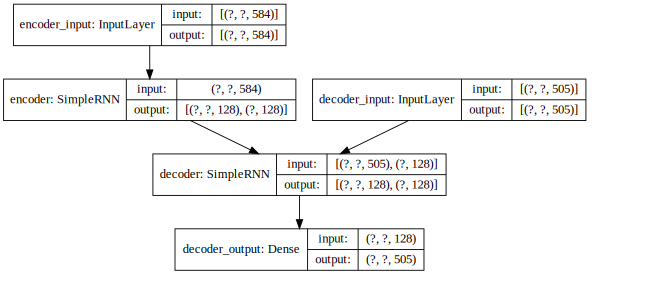

In [36]:
# 모델 확인
SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))
## 이 모델에는 입력으로 항상 '인코더 인풋'과 '디코더 인풋'이 함께 들어가야 하기때문에
## 학습에만 사용하며, 실제 사용에는 '인코더 인풋'만 들어가야 함.
## 대신, 이미 모든 레이어의 학습은 진행되었기 때문에 weights는 학습 되어 있으므로
## 모델의 재구성만 진행하면 사용가능.

In [37]:
# 모델 분리

# 인코더 모델 생성
encoder_model = Model(enc_inputs, enc_state)

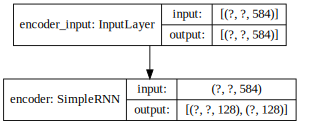

In [38]:
# 인코더 모델 시각화
SVG(model_to_dot(encoder_model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [41]:
# 디코더 모델 생성

# 디코더에서 출력되는 state를 입력하기 위한 
# decoder_state_input이라는 새로운 인풋 레이어 생성
# 디코더 state를 위한 레이어이므로, shape은 디코더의 state와 동일
decoder_state_input = Input(shape=(num_units,), name='decoder_state_input')

# 디코더를 생성하며, 학습에 사용하지 않았던 state를 이번에는 받음.
# 디코더의 초기 weight에 decoder_state_input을 주어
# 이전 SimpleRNN cell의 state를 사용
dec_outputs, dec_state = dec(dec_inputs, initial_state=decoder_state_input)

# 동일한 출력층 설계
dec_outputs = dec_dense(dec_outputs)

# 디코더 모델 생성
# 입력으로, [인코더의 출력] + [이전 디코더 cell의 state] 를 사용하며
# 출력으로, [현재 디코더의 출력] + [현재 디코더의 state] 를 사용
decoder_model = Model(
    [dec_inputs] + [decoder_state_input],
    [dec_outputs] + [dec_state])

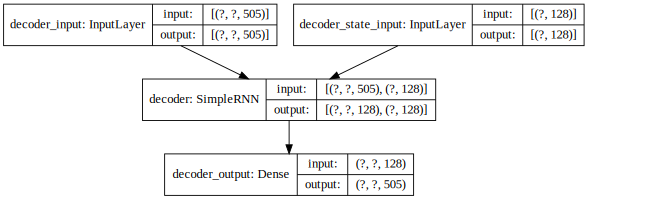

In [42]:
# 디코더 모델 시각화
SVG(model_to_dot(decoder_model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [43]:
# 모델로 한글을 영어로 번역하는 함수 작성

# 한글을 영어로 변역하는 함수로
# 임의의 한글 문장을 
# 정수 인코딩, zero-padding 및 One hot 인코딩을 진행하고,
# 입력에 맞도록 shape만 바꿔서 입력.
def decode_sequence(input_seq):
    
    # 디코더의 초기 입력 중 두번째 입력
    # 인코더를 사용해 한글 문장 인코딩
    state = encoder_model.predict(input_seq)
    
    # 디코더의 초기 입력 중 첫번째 입력
    # 문장의 시작을 뜻하는 Special Symbol인 '<start>'만 추가
    # zero 벡터를 생성하고,
    # '<start>'를 나타내는 One hot 인코딩 생성
    target_seq = np.zeros((1, 1, eng_num_token))
    target_seq[0, 0, eng_words_set.index('<start>')] = 1
    
    # while문 반복 조건을 위한 변수 생성 및 할당
    stop_condition = False
    
    # 디코딩된 영어 문장을 저장하기 위한 변수 생성
    decoded_sentence = []
    
    # stop_condition이 False인 동안 반복
    while not stop_condition:
        
        # 1. 초기 입력인 문장의 시작을 알리는 '<start>'와 One hot 백터와
        # 인코딩된 한글 문장을 디코더에 입력해 출력과 state를 받음
        # state는 변수명이 동일하기 때문에 자동으로 업데이트...
        # 2. 이전 디코더에서 생성된 단어의 Onehot 벡터와 업데이트된 state를
        # 입력으로 사용해 디코더의 새로운 출력과 state를 받음, 나머지 동일하게 진행
        output_token, state = decoder_model.predict([target_seq]+[state])
        
        # 출력에서 제일 큰 수가 있는 index를 받음
        sampled_token_index = np.argmax(output_token[0, -1, :])
        
        # 영어 단어 집합에서 index번째의 단어를 찾음
        sampled_word = eng_words_set[sampled_token_index]
        
        # 디코더 출력에서 제일 큰 수가 있는 index가 0이면 ''이기 때문에 저장하지 않음.
        # 즉, 0이 아니면 저장.
        if sampled_token_index != 0:
            decoded_sentence.append(sampled_word)
        
        # 출력된 단어가 문장의 끝을 알리는 '<eos>'라면 
        # 반복을 멈추기 위해 조건 변경
        if sampled_word == '<eos>':
            stop_condition = True
        
        # 현재 출력된 단어를 One hot 벡터로 생성해 
        # 다음번 디코더의 입력으로 사용.
        target_seq = np.zeros((1, 1, eng_num_token))
        target_seq[0, 0, sampled_token_index] = 1
    
    # 디코딩된 문장에서 마지막은 <eos>가 들어있기 때문에
    # 마지막 단어를 제외하고 반환
    return decoded_sentence[:-1]

In [44]:
# decode_sequence로 연결해 주는 중간 계층
def translate(input_seq):
    decode_sequences = decode_sequence(input_seq)
    return decode_sequences

In [45]:
# 테스트용 인코더 입력 데이터 생성 및 확인

# 모델에 학습된 데이터를 사용해 한글->영어 번역 확인
enc_sent = [kor_words_set[np.argmax(word_vec)] 
            for word_vec in encoder_train[0] if np.argmax(word_vec) != 0]
print(len(enc_sent))
print(enc_sent)

8
['나는', '네가', '한국', '언어를', '배워서', '한국어로', '대화했으면', '좋겠어.']


In [46]:
# 번역 및 결과 확인
sentence = translate(encoder_train[0].reshape(1, kor_max_len, -1))
print(len(sentence))
print(sentence)

12
['I', 'want', 'you', 'to', 'learn', 'Korean', 'and', 'talk', 'with', 'me', 'in', 'Korean.']


In [47]:
# 한글 -> 영어 결과 비교
print(' '.join(enc_sent))
print(' '.join(sentence))

나는 네가 한국 언어를 배워서 한국어로 대화했으면 좋겠어.
I want you to learn Korean and talk with me in Korean.


In [48]:
print(len(kor_words_set))
print(kor_words_set)

584
['', '10시에', 'Ann이라고', '가', '가까이', '가는', '가능하신가요?', '가능한', '가능할까요?', '가르쳐', '가야', '가장', '가졌으면', '가족들과', '가지고', '가지씩', '가집시다.', '간다면', '감사드립니다.', '감사하겠습니다.', '감탄사를', '갔다.', '강아지와', '같아.', '같아요.', '같은', '같이', '개를', '개와', '거', '거리에', '거야.', '거에요.', '거예요.', '거의', '거짓말을', '걱정했었다.', '건', '건강한', '걸린다.', '걸어다니며', '것', '것으로', '것을', '것이', '것입니다.', '것처럼', '게임도', '결정하게', '결정했어요.', '결혼해서', '경기', '계약을', '계획하려', '고기를', '고소할', '곳까지는', '곳에', '곳을', '곳이', '공부하고', '공부하기로', '공부하는', '공부했었습니다.', '공장이', '관심에', '관심을', '관해', '광주에서', '국회', '귀국하는', '귀를', '그', '그가', '그녀가', '그는', '그대로', '그들', '그때', '그런', '그럴듯한', '그만두었습니다.', '근데', '금융업에', '기간을', '기간이', '기쁩니다.', '기억만', '깨달았습니다.', '꼭', '꽤', '꿈', '나눠', '나뉘어', '나는', '나도', '나랑', '나를', '나에게', '나였으면', '나와', '나의', '날씨가', '남산', '내', '내가', '내게', '내고', '내일', '너는', '너랑', '너무', '너의', '네,', '네가', '노력해요.', '놀랐다.', '놀이에', '눈과', '다', '다가왔어요.', '다른', '다시', '다음과', '단지', '달', '달라고', '달린', '달의', '당신', '당신들과', '당신들은', '당신의', '당신이', '대고', '대나무로', '대략', '대여하여', '대한', '대해', '대해서', '대화하는

In [51]:
kor_sent = '혹시 한국 전통술에 막걸리를 먹어야 되나요?'

# 위에서 작성한 함수를 사용해
# 한글 문장 정수 인코딩 및 zero-padding 진행
enc_kor_sent = kor_encoding(kor_sent)
print(enc_kor_sent)

[  0.   0.   0.   0.   0.   0. 568. 533. 425. 180. 200. 161.]


In [ ]:
# 정수 인코딩 및 zero-padding이 진행된 한글 문장을
# to_categorical() 함수를 사용해 One hot 인코딩 진행 및
# enc_kor_sent는 정수 인코딩 및 zero-padding이 진행된 한글 문장이며, 
# num_classes는 One hot 인코딩을 진행할때 필요한 전체 한글 단어의 개수
# 입력을 위해 3차원으로 shape 변경
sentence = translate(to_categorical(enc_kor_sent, num_classes=len(kor_words_set)).reshape(1, kor_max_len, -1))
print(len(sentence))
print(' '.join(sentence))